# Neural Style Transfer
**This notebook was adapted from a Colab notebook provided by Google found [here](https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb). I have added some functions to facilitate performing neural style transfer using images rescaled to a set of octaves.**
<br>
This notebook performs neural style transfer using a pair of images. The process uses the layers of a pre-trained convolutional neural network to generate a composite image consisiting of the style of one image and the content of another. The classic example of this process is to transfer the style of famous paintings to content images to make those images look as though they were painted by the artist.

## Preprocessing of images
<br>
We need to start by uploading the images that we are going to use for the style transfer and performing some preprocessing to get them into a format that the neural network can interact with.
<br>
This cell imports the modules that we will use in this notebook and defines functions for loading and processing the images.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd

from PIL import Image
import time
import functools

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import IPython.display

from google.colab import files
import cv2

def upload_img():
  max_dim = 1500
  img = files.upload()
  img_name = [x for x in img.keys()][0]
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  cv2.imwrite(img_name, img) 
  img = Image.open(img_name)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

The content image is loaded in this cell.

Saving gorilla.jpg to gorilla (2).jpg


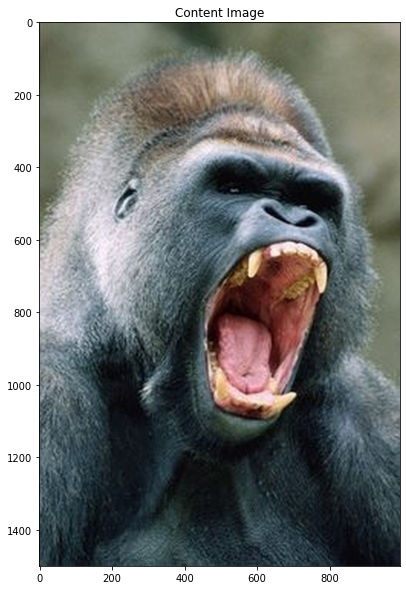

In [101]:
content = upload_img()
imshow(content, 'Content Image')

The style image is loaded in this cell.

Saving fire_tile_2.jpg to fire_tile_2.jpg


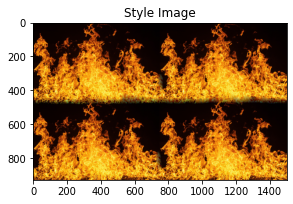

In [97]:
style = upload_img()
imshow(style, 'Style Image')

## Initialization of neural network parameters
In this section, we choose the neural network that we want to use to perform the style transfer. I have generally had good luck with VGG networks, but any image recognition CNN can be used for this process. The style and content layers used to minimize the objective function must be adapted for the chosen network. *More discussion is included below during the step where these layers are defined.*
<br>
In this cell, the network is defined. Replacing max pooling layers with average pooling layers produces a slightly better result.

In [5]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
preprocessing_class = tf.keras.applications.vgg16

def replace_max_by_average_pooling(model):
    input_layer, *other_layers = model.layers
    assert isinstance(input_layer, tf.keras.layers.InputLayer)

    x = input_layer.output
    for layer in other_layers:
        if isinstance(layer, tf.keras.layers.MaxPooling2D):
            layer = tf.keras.layers.AveragePooling2D(
                pool_size=layer.pool_size,
                strides=layer.strides,
                padding=layer.padding,
                data_format=layer.data_format,
                name=f"{layer.name}_avg",
            )
        x = layer(x)

    return tf.keras.models.Model(inputs=input_layer.input, outputs=x)

def get_model(base_model):
  # Load our model.
  model = base_model
  model.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [model.get_layer(name).output for name in style_layers]
  content_outputs = [model.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(model.input, model_outputs)

base_model = replace_max_by_average_pooling(base_model)
base_model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool_avg (AveragePool (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool_avg (AveragePool (None, None, None, 128)  

This cell defines functions for rescaling and processing images.
<br>
Performing the style transfer multiple times with content and style images scaled to various extents can produce a superior result. The *rescale_img* function is used to scale the image by a factor of *octave_scale* to the *n_octave* power.
<br>
The processing steps are required for the images to be compatible with the neural network. For the popular image recognition CNNs, a function for performing these steps is typically included in the package. 
<br>
The *deprocess_img* function was written specific to inverse the VGG preprocessing steps. VGG uses a common preprocessing operation, but this function will not apply generally for all CNNs.

In [88]:
def rescale_img(
    content_img,
    octave_scale=1.50,
    n_octave=-1,
    ):

  img = tf.constant(np.array(content_img))
  base_shape = tf.shape(img)[:-1]
  float_base_shape = tf.cast(base_shape, tf.float32)

  new_shape = tf.cast(float_base_shape*(octave_scale**n_octave), tf.int32)

  img = tf.image.resize(img, tf.slice(new_shape, [1], [2])).numpy()
  
  return(img)

def rescale_and_process_img(img,preprocessing_class,octave_scale=1.5,n_octave=-1):
  img = rescale_img(img, octave_scale, n_octave)
  img = preprocessing_class.preprocess_input(img)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x



We need to specify the layers that contain the information we want to retain in the content and style images. Different approaches can be schemed out here to produce different composite images. Generally speaking, the more layers chosen, the more information retained - i.e., if we choose only one content layer and several style layers, we can expect that the resulting image will try to keep more style from the style image at the expense of content from the content image. Additionally, lower layers contain "deeper" levels of information than upper layers - i.e., more significant changes in content (or style) will be observed if only higher level layers are included.
<br>
<br>
For this example, we want to produce a composite image transfers a lot of style to the content image, so only one high level layer is chosen for the content image and layers across multiple depths are chosen for the style image. Try experimenting with different layers to produce different results.

In [9]:
# Content layer where will pull our feature maps
# VGG16
blocks = ['5']
convs = [x for x in range(1,2)]
content_layers = ['block'+str(x)+'_conv'+str(y) for x in blocks for y in convs]

print('Content Layers')
print(content_layers)
print('')

# Style layer we are interested in
# VGG16
blocks = [x for x in range(1,6)]
convs = [x for x in range(1,3)]
style_layers = ['block'+str(x)+'_conv'+str(y) for x in blocks for y in convs]
blocks = [x for x in range(3,6)]
convs = [x for x in range(3,4)]
style_layers_2 = ['block'+str(x)+'_conv'+str(y) for x in blocks for y in convs]
style_layers = style_layers + style_layers_2

print('Style Layers')
print(style_layers)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Content Layers
['block5_conv1']

Style Layers
['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block4_conv1', 'block4_conv2', 'block5_conv1', 'block5_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']


## Definition of objective function
We need to define an objective function for the program in the optimization process. The objective function for neural style transfer involves parameters from both the content and style components.

In [6]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)



In [7]:
def get_feature_representations(model, content, style, preprocessing_class, octave_scale, n_octave):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content: The content image.
    style: The style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = rescale_and_process_img(content,preprocessing_class,octave_scale=octave_scale,n_octave=n_octave)
  style_image = rescale_and_process_img(style,preprocessing_class,octave_scale=octave_scale,n_octave=0)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

## Run program

In [94]:
def run_style_transfer(
    content, 
    style,
    octave_scale=1.50,
    n_octave=0,
    num_iterations=1000,
    content_weight=1e2,
    style_weight=1e-3,
    base_model=base_model,
    preprocessing_class=preprocessing_class
    ): 

  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model(base_model) 
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content, style, preprocessing_class, octave_scale, n_octave)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = rescale_and_process_img(content,preprocessing_class,octave_scale=octave_scale,n_octave=n_octave)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create optimizer
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.9, beta_2=0.999, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  all_imgs = imgs
      
  return best_img, best_loss, all_imgs

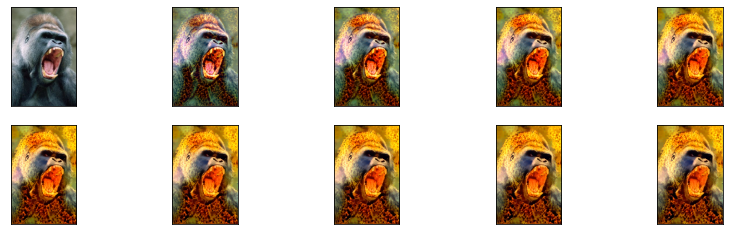

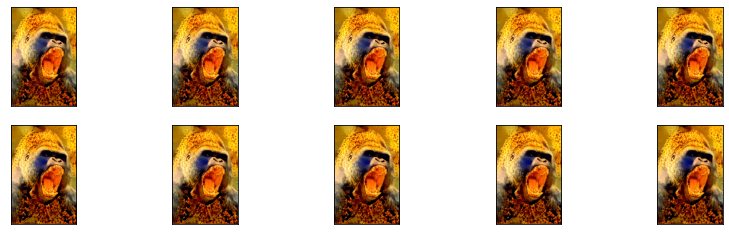

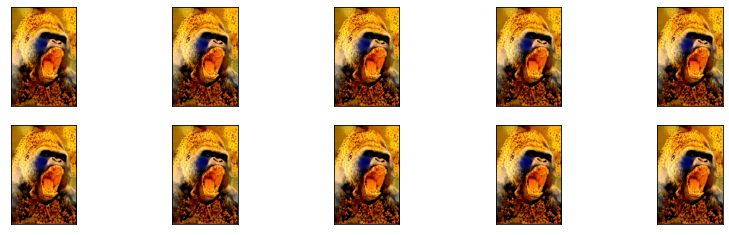

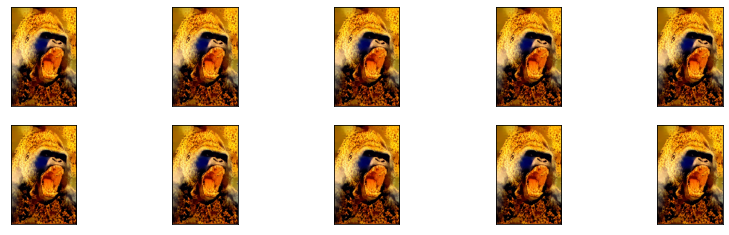

In [99]:
for n in [-5,1,1,1]:
  print(n)

  best_img, best_loss, all_imgs = run_style_transfer(
      content, 
      style, 
      octave_scale=1.20,
      n_octave=n,
      num_iterations=1000,
      )
  
  content = np.expand_dims(best_img, axis=0)


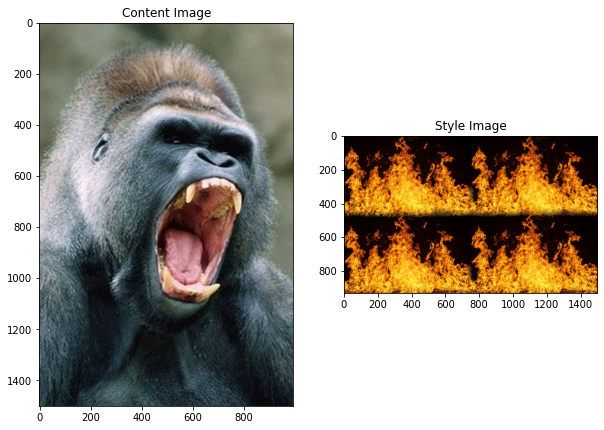

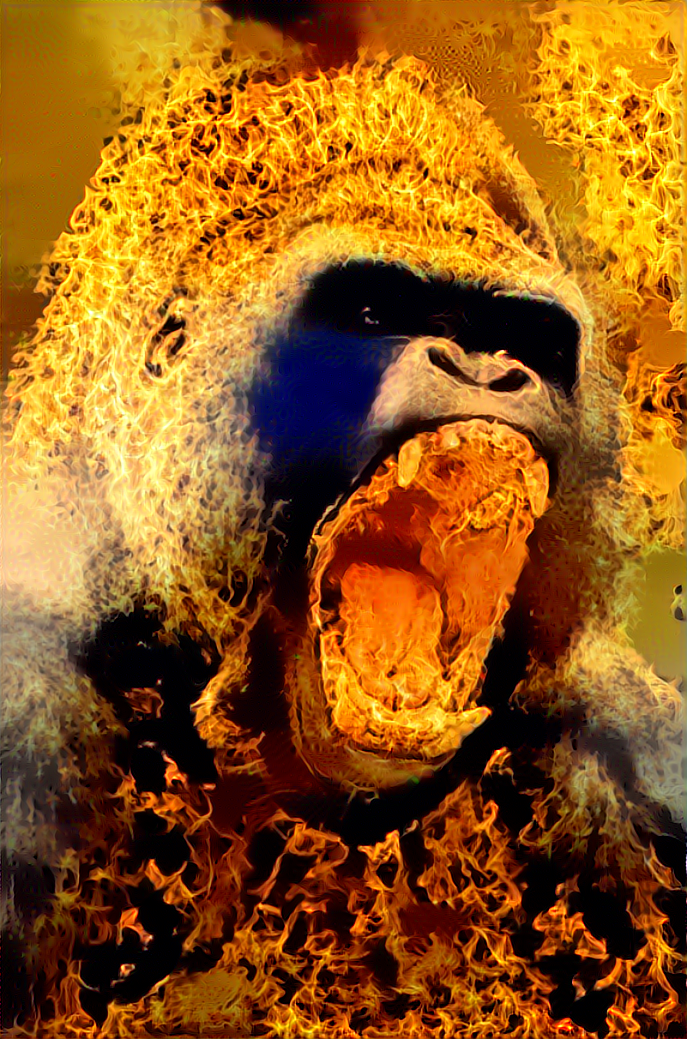

In [105]:
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Image.fromarray(best_img)
